# Exercise Sheet 2 - CIFAR, MLP, Overfitting, and Regularization

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Monday, Nov 21, before 14:00**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement a MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2`.
- Make only one submission of the exercise per group.
- The deadline is strict
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution into the marked cells.


## Imports

In [1]:
import os
import fastprogress
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

### GPU and Cuda checks

In [2]:
# DO NOT CHANGE
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [3]:
# DO NOT CHANGE
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: False ; cudnn available: False ; num devices: 0
Using device cpu
4 CPUs available


**Recommendation:** Use GPU or TPU for faster model training. Exercise Sheet 1 explains how to do that on Kaggle.

## Load data

In [4]:
# DO NOT CHANGE
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                              num_workers=num_cpus)
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(data_dir, download=True, train=True, 
                                            transform=normalized_transform) 
    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(data_dir, download=True, train=False, 
                                           transform=normalized_transform)

    return trainset, testset, dataset_mean, dataset_std
        
        
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(trainset, 
                                  (num_train_samples, num_val_samples), 
                                  generator=torch.Generator().manual_seed(split_seed))
    return trainset, valset
    
    
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """        
    trainloader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_cpus)
    valloader = torch.utils.data.DataLoader(valset, 
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=num_cpus)
    testloader = torch.utils.data.DataLoader(testset,
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=num_cpus)
    return trainloader, valloader, testloader

#### TODO
- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.

*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [5]:
trainset, testset, dataset_mean, dataset_std = grab_data("data/")
trainset, valset = generate_train_val_data_split(trainset);
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the dataset.

#### TODO
- Print all class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [30]:
def imshow(img, mean, std):
    """Undo normalization using mean and standarddeviation and show image.

    Args:
        img (torch.Tensor): Image to show
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    N = 16
    # Undoing normalization
    img = img * std[:, None, None] + mean[:, None, None]
    plt.axis('off')
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


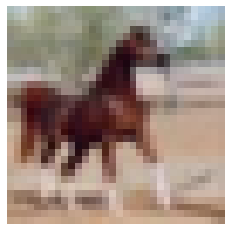

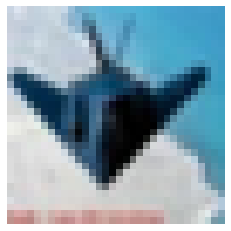

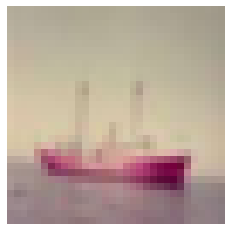

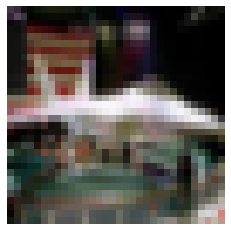

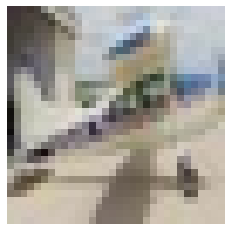

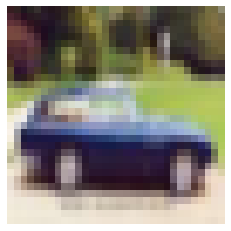

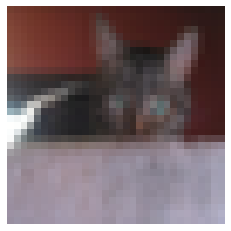

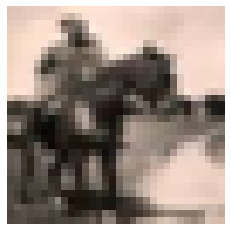

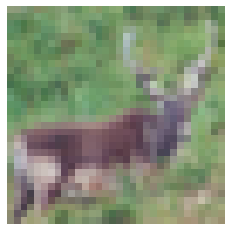

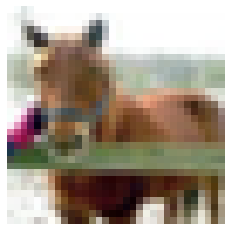

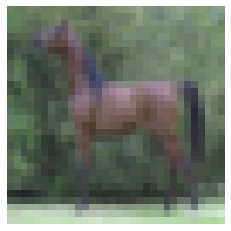

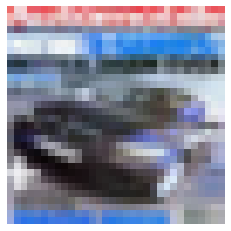

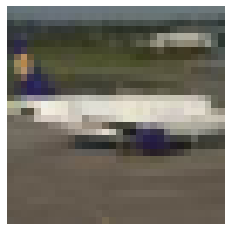

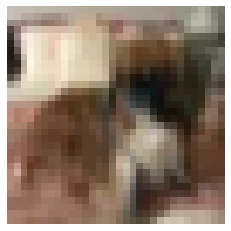

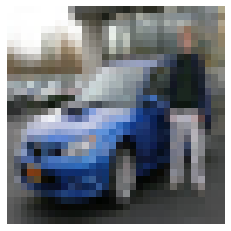

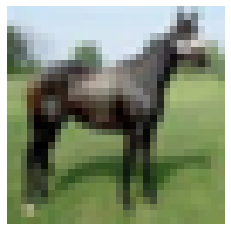

In [32]:
# Create actual plot and print the class names

N = 16

print(trainset.dataset.classes)

for i, (image, label) in enumerate(trainloader):
    if i == N:
        break
    j = np.random.randint(image.shape[0])
    imshow(image[j], dataset_mean, dataset_std)

## Training, evaluation and plotting functions from Exercise 1

Here, we provide examples of the functions you implemented on the first exercise sheet to you. Some parts are still missing. You can ignore that for the time being, as you will implement that later as soon as the according functionality is required.

In [42]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.early_stopping(epoch_val_acc, model)
            # raise NotImplementedError # Comment out this keyword after your implementation
            
            if early_stopper.early_stop:
                early_stopper.epoch = epoch
                if verbose:
                    master_bar.write("Early stopping...")
                
                # load the last checkpoint with the best model
                model.load_state_dict(torch.load(early_stopper.path))
                break
    
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        # raise NotImplementedError # Comment out this keyword after your implementation

        plt.scatter(extra_pt[0], extra_pt[1], c='black', zorder=2)
        legend.append(extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs

*Hint*: As CIFAR 10 contains color images, amongst other dimensions you want to flatten the color channel dimension, too.

In [34]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, img_width, num_in_channels, num_classes, 
                 num_hidden_units=30, num_hidden_layers=1, act_fn=None):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        super(MLP, self).__init__()
        
        self.img_width = img_width
        self.num_in_channels = num_in_channels
        self.num_hidden_layers = num_hidden_layers
        
        # Setting up layers
        self.ilayer = torch.nn.Linear(img_width * img_width * num_in_channels, num_hidden_units)
        self.hlayers = torch.nn.Linear(num_hidden_units, num_hidden_units)
        self.olayer = torch.nn.Linear(num_hidden_units, num_classes)
        # Setting up activation fuction
        self.act_fn = act_fn if act_fn else torch.nn.ReLU()
    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        # Flattenning
        x = x.view(-1, self.img_width * self.img_width * self.num_in_channels)
        # Applying layers and activations
        out = self.ilayer(x)
        out = self.act_fn(out)
        for num_hidden_layer in range(self.num_hidden_layers):
            out = self.hlayers(out)
            out = self.act_fn(out)
        out = self.olayer(out)
        return out


## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we do not use SGD as in exercise 1, but the commonly used Adam optimizer, since it behaves more robustly and is easy to use.

#### TODO
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*

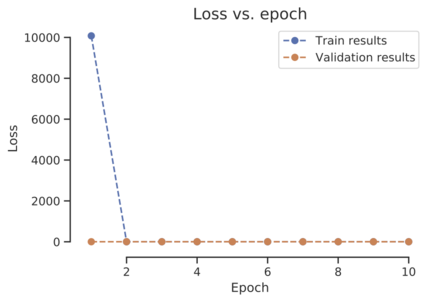

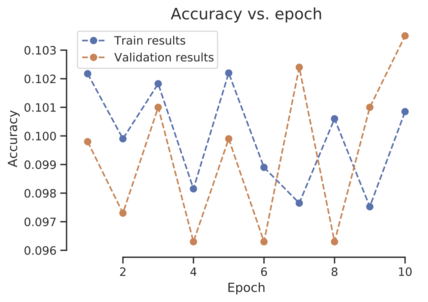

**This is an example of a model that does train:** *(Why?)*

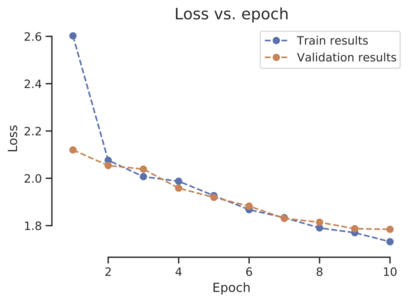

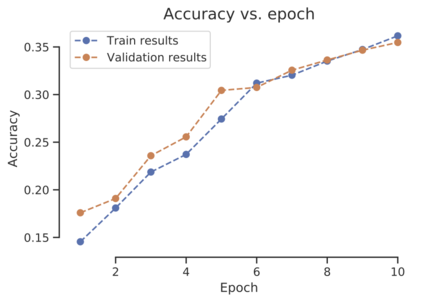

Finished training after 120 seconds.


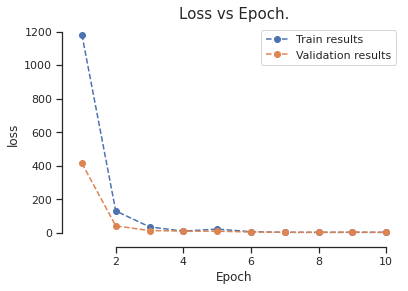

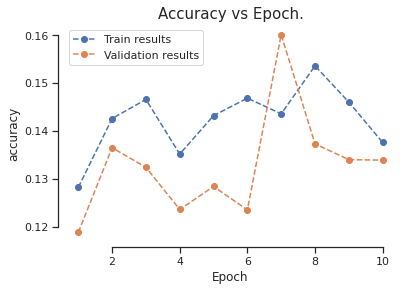

In [100]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-0
epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)
plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

Finished training after 140 seconds.


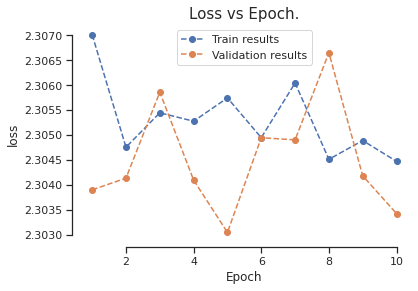

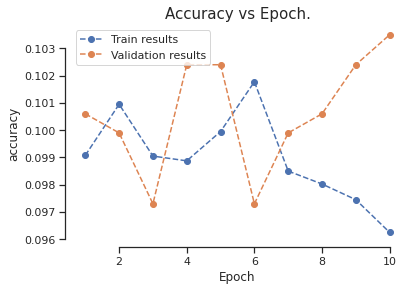

In [37]:
lr = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

Finished training after 143 seconds.


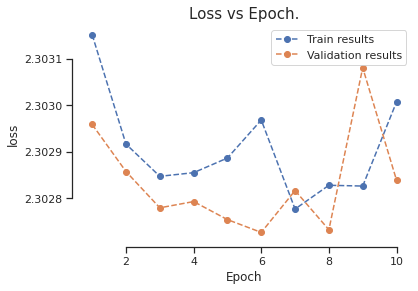

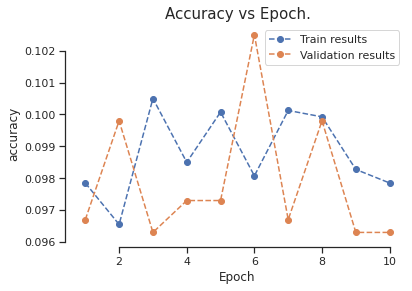

In [38]:
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

Finished training after 144 seconds.


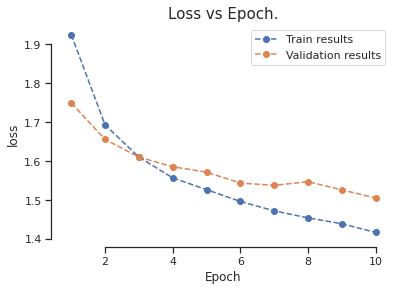

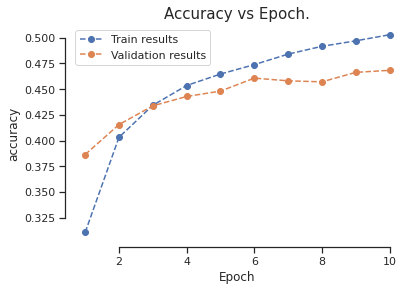

In [15]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-3
epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

Finished training after 171 seconds.


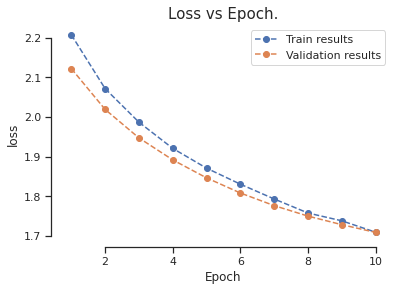

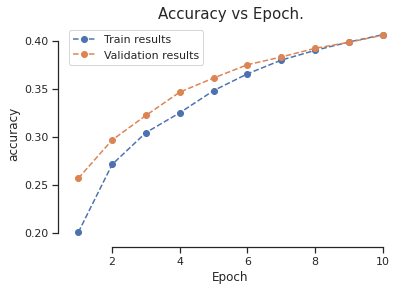

In [13]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-4
epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

Finished training after 1259 seconds.


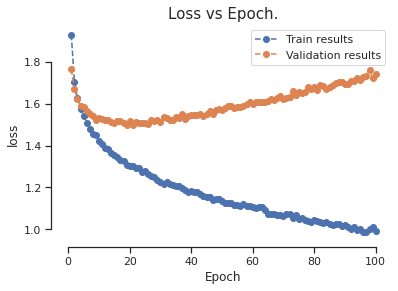

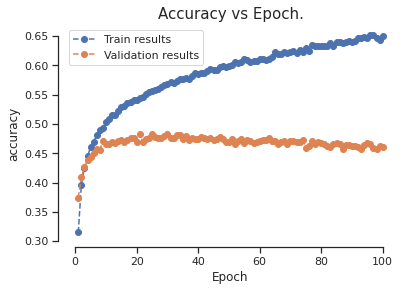

In [10]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-3
epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

Finished training after 1163 seconds.


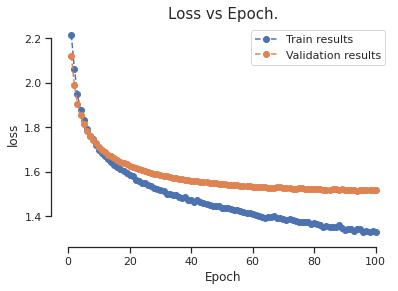

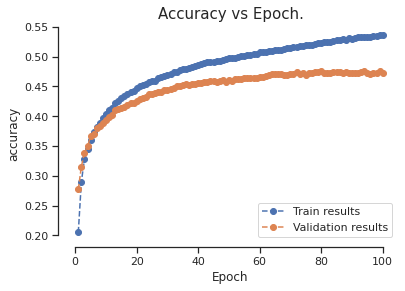

In [10]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-4
epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your todo's:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

In [11]:
bestloss = min(val_losses)
bestacc = max(val_accs)

print(f"Best loss value {bestloss} in epoch {val_losses.index(bestloss)}")
print(f"Best loss value {bestacc} in epoch {val_accs.index(bestacc)}")

Best loss value 1.5164484977722168 in epoch 93
Best loss value 0.4752 in epoch 93


Let's have a look at those training curves! Here are some questions for you.

#### TODO
Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the overall minimum of the curve.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:
1. It decreases because after each epoch the model is learning and the loss function is implemented in such a way the losses decrease
2. Yes, overall it decreases, but there are fluctuations in the validation data because learning happens on training dataset and not on validation dataset. Convergence to minimum of the convex loss curve is related to the training data and not validation data.
3. Yes, the model is trying to learn the training set by improves the weight after each epoch. But in case of validation accuracy, even though we see an overall increasing trend but there are times where it decreases, indicating overfitting.
4. Yes. We got best validation loss and accuracy at the same epoch.
5. Since these two are different metrics and different function behaviours. It doesn't have to be from the same epoch.
6. At epoch 93 it reached a 47.52% accuracy, this would be the best model to make predictions. Since we are getting the best accuracy at this point and everything after this is going towards overfitting with accuracy and loss decreasing. The graph for accuracy shows that the model is learning the training set but the validation accuracy is not changing, rather the gap increases gradually indicating overfitting.

## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [13]:
# Saving in disk
path = "data/checkpoint.pt"
if model:
    torch.save(model.state_dict(), path)

In [22]:
# Intializing new model
model2 = MLP(32, 3, 10)
model2.load_state_dict(torch.load(path))
model2 = model2.to(device)

In [23]:
# Computing validation
mnlossm, accm, cnfmxm = validate(valloader, model, loss_function, device, None)
mnlossm2, accm2, cnfmxm2 = validate(valloader, model2, loss_function, device, None)

print("Loss in model 1:", mnlossm)
print("Loss in model 2:", mnlossm2)
print("Accuracy in model 1:", accm)
print("Accuracy in model 2:", accm2)

Loss in model 1: 1.5184877276420594
Loss in model 2: 1.517085647583008
Accuracy in model 1: 0.4723
Accuracy in model 2: 0.4723


## Early stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [35]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): The number of epochs that are to going to be waited before the early stop is raised
                Defaults to 1
        """
        self._verbose = verbose
        self._path = path
        self._patience = patience
        # Criteria
        self._stop = False
        self._epoch = -1
        # Accuracy criteria
        self._maxacc = 0
        # Patience
        self._wait = 0

    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        return self._stop

    @property
    def path(self):
        """Path where checkpoint is stored
        
        Returns:
            [str]: The path of the checkpoint declared in the constructor
        """
        return self._path
    
    @property
    def epoch(self):
        """Epoch where early stop was reached
        
        Returns:
            [int]: Early stop epoch
        """
        return self._epoch
    
    @epoch.setter
    def epoch(self, epoch):
        """Epoch where early stop was reached
        
        Args:
            epoch (int): Early stop epoch
        """
        self._epoch = epoch
        
    @property
    def mtuple(self):
        """Tuple where early stop was reached
        
        Returns:
            [tuple]: X and Y points where early stop was reached
        """
        return (self._epoch - self._wait + 1, self._maxacc)
    
    def early_stopping(self, val_acc, model):
        """Evaluates the early stop with the patience given
        """
        if val_acc > self._maxacc:
            self._maxacc = val_acc
            torch.save(model.state_dict(), self.path)
            self._wait = 0
        else:
            self._wait += 1

            if self._wait == self._patience:
                self._stop = True

#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

Finished training after 344 seconds.


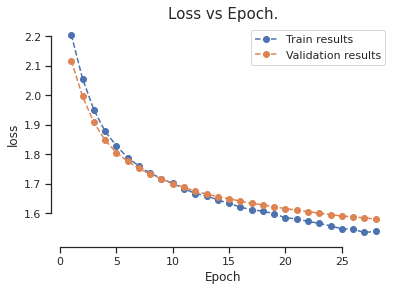

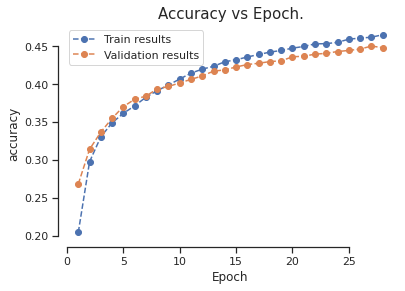

In [40]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-4
epochs = 100

early_stopper = EarlyStopper() # path='data/checkpoint-earlystop.pt'

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

Finished training after 279 seconds.


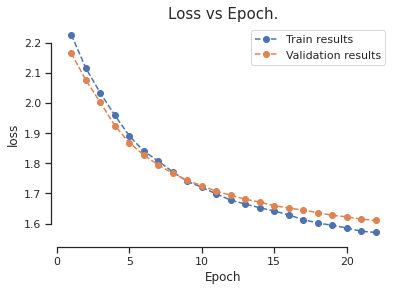

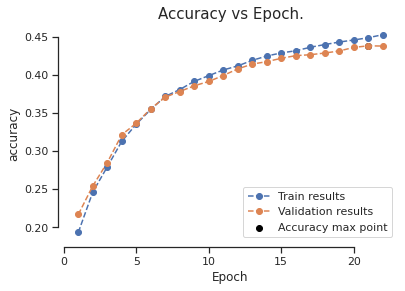

In [67]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-4
epochs = 100

early_stopper = EarlyStopper()

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")

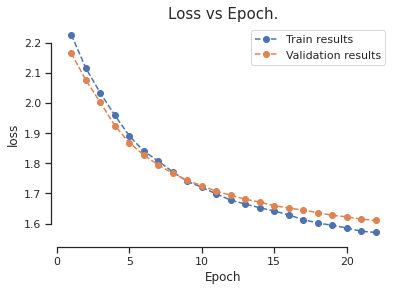

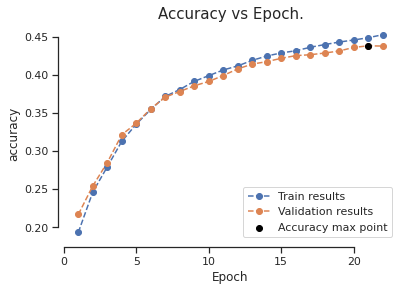

In [73]:
plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")

#### TODO
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not? _It didn't train enough because the early stop stopped the training after 1 epoch that got a below result (with patience=1)_
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs? _Yes, the model was able to learn with different patience values and get better accuracy values without having to train the 100 epochs_

Finished training after 514 seconds.


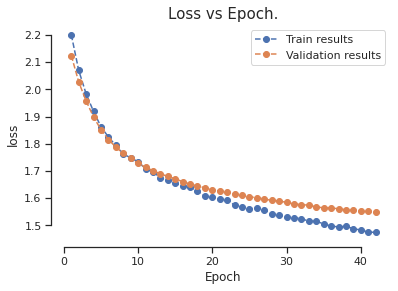

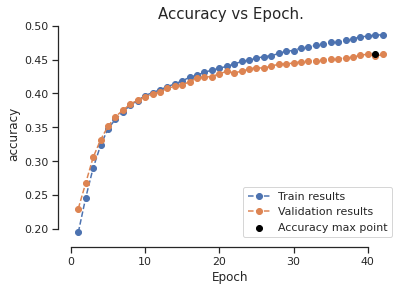

In [76]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-4
epochs = 100

early_stopper = EarlyStopper(patience=2)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")

Finished training after 202 seconds.


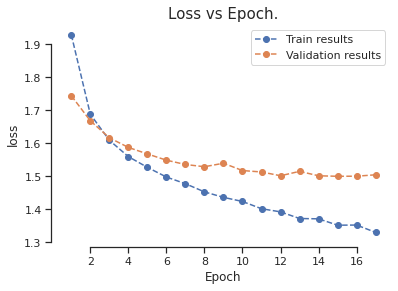

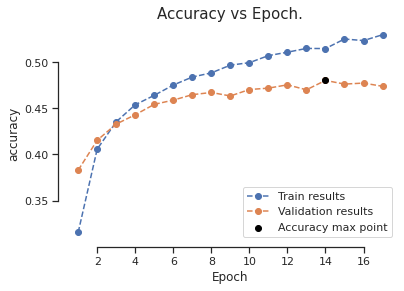

In [82]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-3
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")

Finished training after 654 seconds.


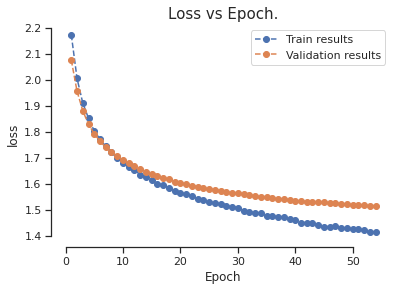

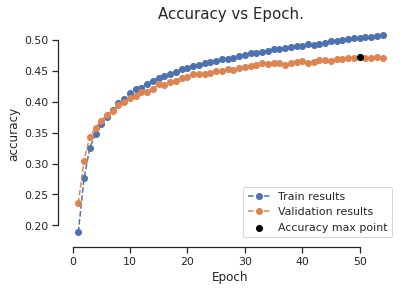

In [84]:
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
lr = 1e-4
epochs = 100

early_stopper = EarlyStopper(patience=4)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")

In [103]:
early_stopper.mtuple

(50, 0.4728)

## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do? _The lr 1e-3 was more accurate and coverges slower. It took longer to train the lr 1e-4 model, so it decreases the time as we increase the lr. We would choose the 1e-3 lr model_

Finished training after 279 seconds.


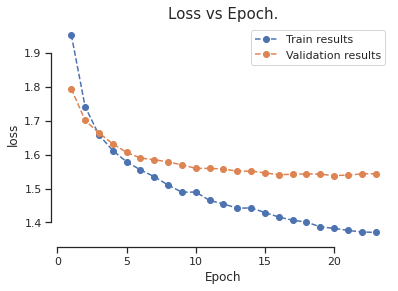

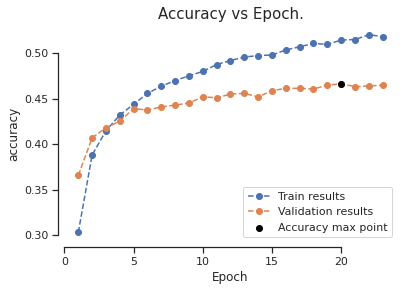

(20, 0.4662)

In [104]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 835 seconds.


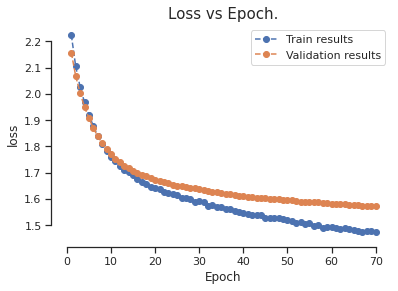

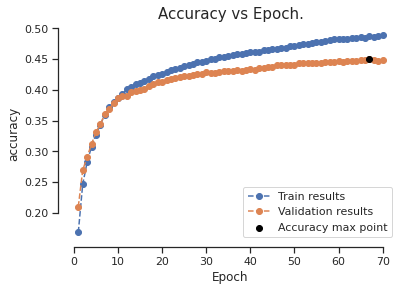

(67, 0.4495)

In [105]:
lr = 1e-4
# Model declaration
model = MLP(32, 3, 10)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

## Explore batch size *(optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(optional)*
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [ ]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################



In [ ]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################



# What about the architecture?

How does architecture affect predictive performance? _It depends on several factor on the complexity of the paramaters, how much data do we have, learning rate, early stop, etc_ 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers
- activation function used

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

# number of hidden units

Finished training after 149 seconds.


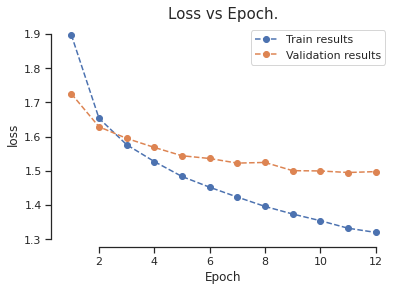

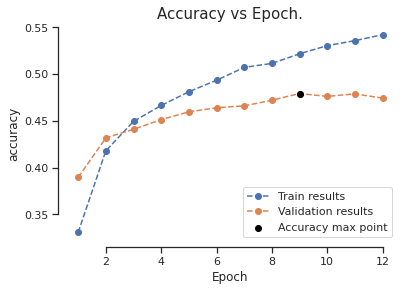

(9, 0.4791)

In [106]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_units=60)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 214 seconds.


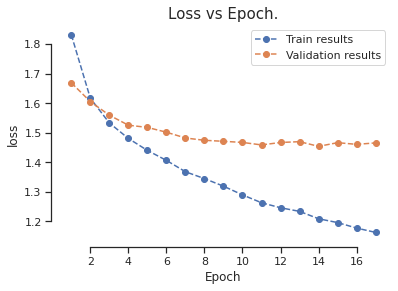

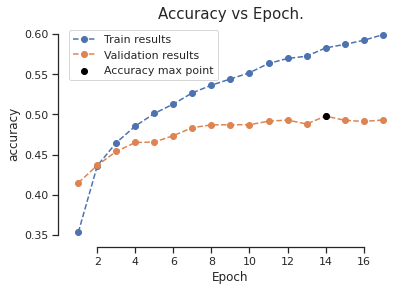

(14, 0.4979)

In [107]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_units=90)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 237 seconds.


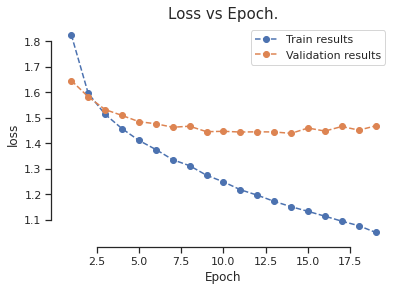

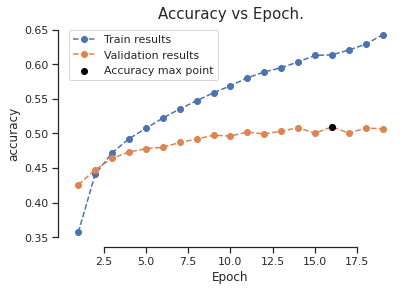

(16, 0.5097)

In [108]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_units=120)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 180 seconds.


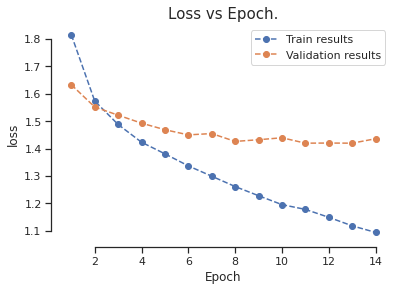

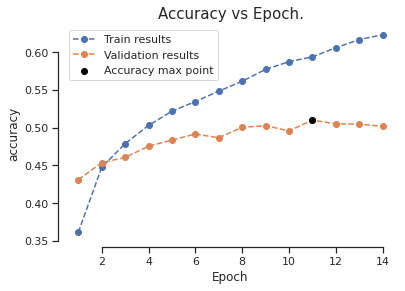

(11, 0.5101)

In [109]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_units=150)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 215 seconds.


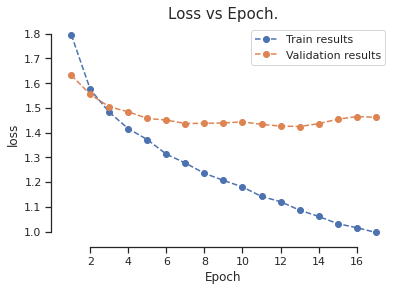

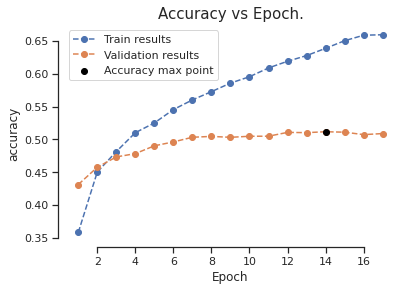

(14, 0.5117)

In [110]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_units=180)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 219 seconds.


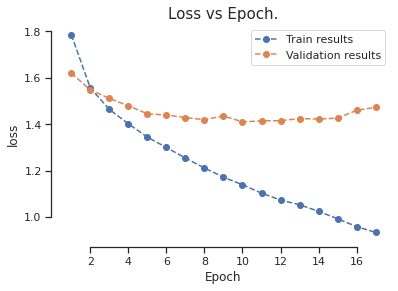

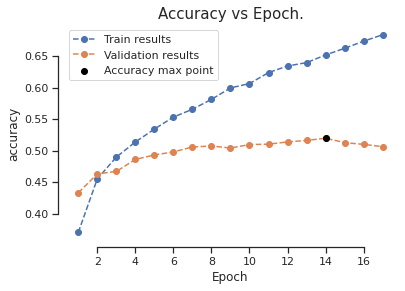

(14, 0.5197)

In [111]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_units=210)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 127 seconds.


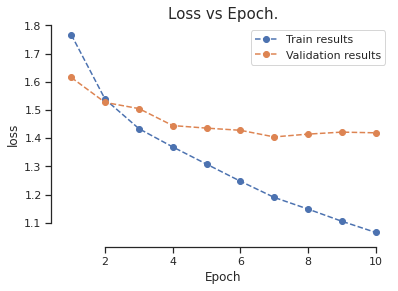

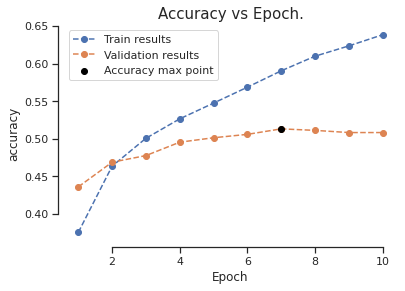

(7, 0.5132)

In [112]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_units=300)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

# number of layers

Finished training after 294 seconds.


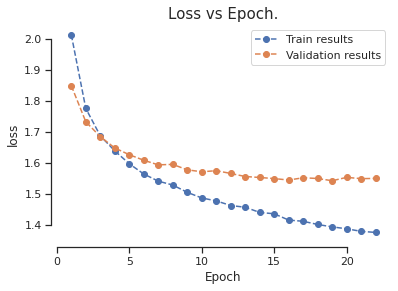

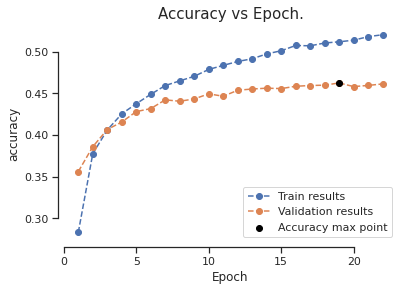

(19, 0.4623)

In [115]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=1)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 311 seconds.


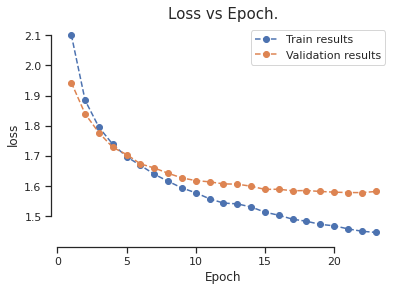

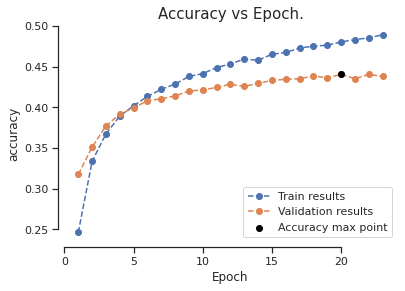

(20, 0.4405)

In [113]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=2)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 671 seconds.


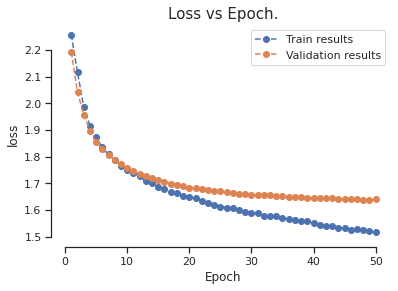

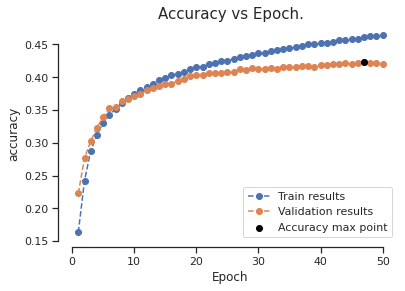

(47, 0.4233)

In [114]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=4)
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

# activation function

Finished training after 366 seconds.


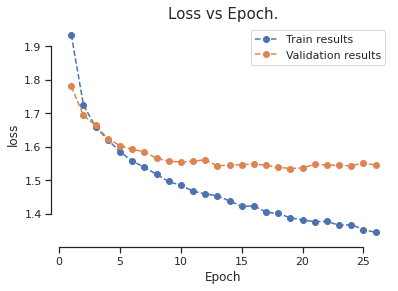

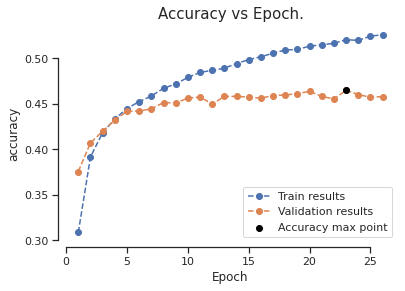

(23, 0.4651)

In [121]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, act_fn=torch.nn.ReLU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 248 seconds.


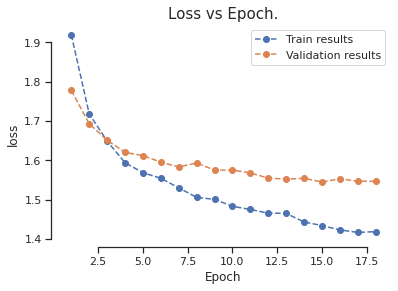

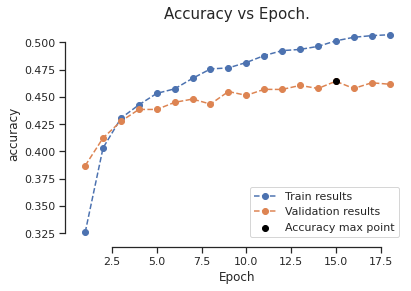

(15, 0.4643)

In [120]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, act_fn=torch.nn.PReLU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 140 seconds.


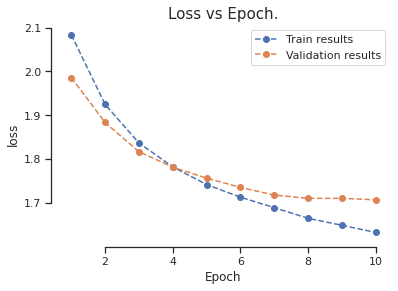

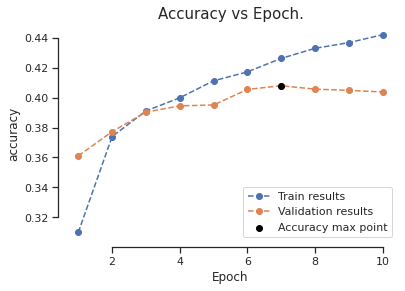

(7, 0.4081)

In [122]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, act_fn=torch.nn.Tanh())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 231 seconds.


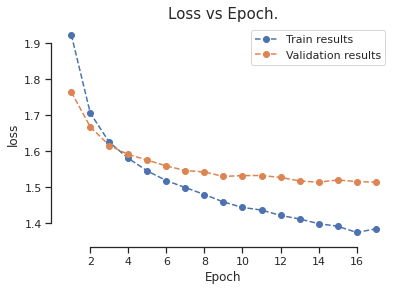

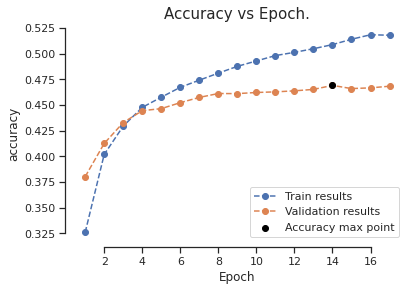

(14, 0.469)

In [123]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, act_fn=torch.nn.ELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 235 seconds.


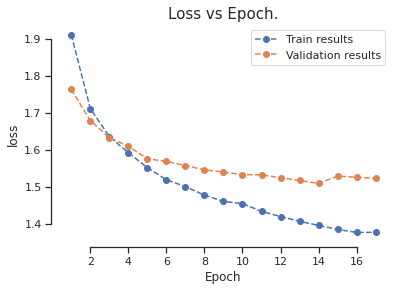

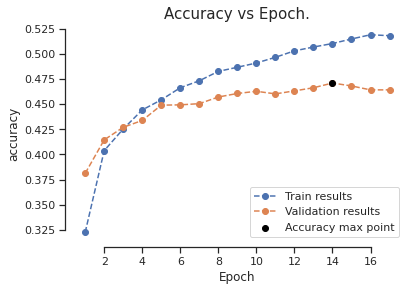

(14, 0.471)

In [124]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, act_fn=torch.nn.SELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?



**Your answers:**
- We got an accuracy above 50% when changing number of hidden units!
- Number of hidden units and layers
- Not necessarly, because in some cases the accuracy decreases (it gets worse)

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why? _No, because the model overfits, it's learning too much_
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get? _We got 52%_
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

Finished training after 216 seconds.


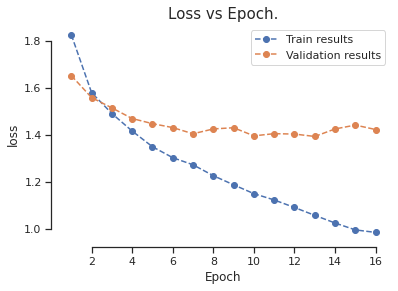

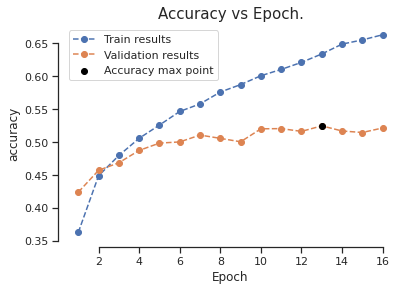

(13, 0.5249)

In [125]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=1, num_hidden_units=210, act_fn=torch.nn.SELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 510 seconds.


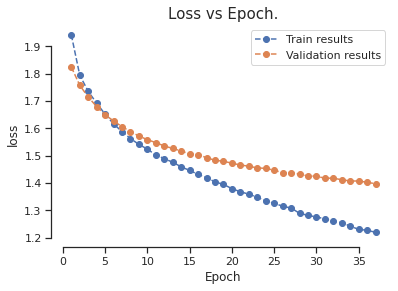

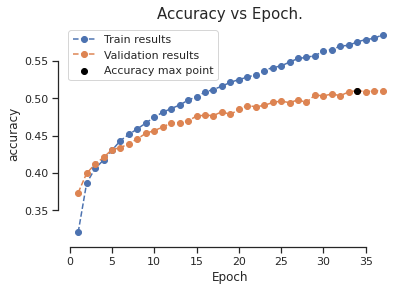

(34, 0.5105)

In [126]:
lr = 1e-4
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=1, num_hidden_units=210, act_fn=torch.nn.SELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 230 seconds.


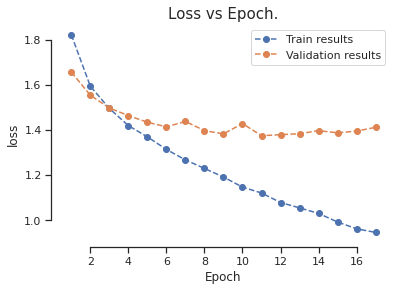

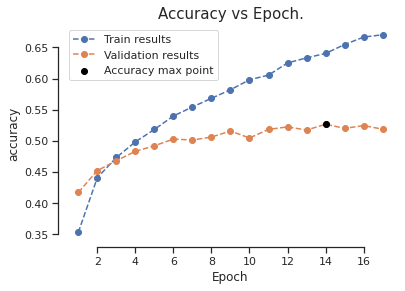

(14, 0.5267)

In [127]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=3, num_hidden_units=210, act_fn=torch.nn.SELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 190 seconds.


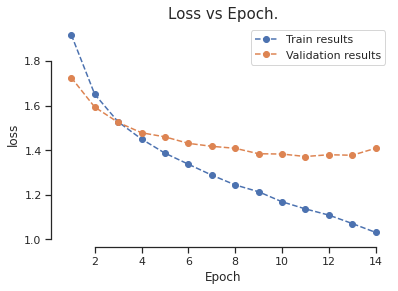

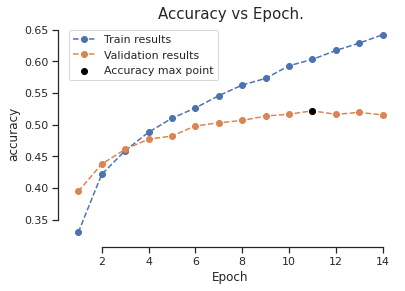

(11, 0.5219)

In [128]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=6, num_hidden_units=240, act_fn=torch.nn.SELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then? _It changes, because it has the stochastic way of learning_
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

Finished training after 171 seconds.


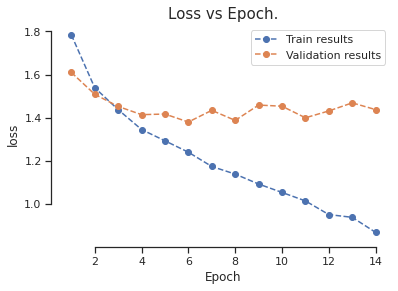

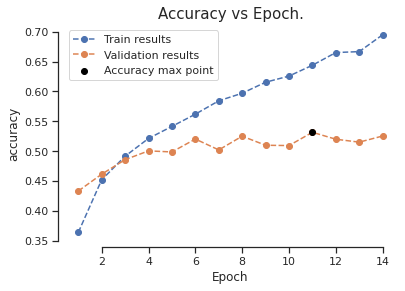

(11, 0.5316)

In [38]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=3, num_hidden_units=210, act_fn=torch.nn.SELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 151 seconds.


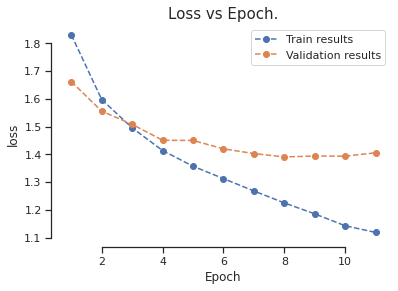

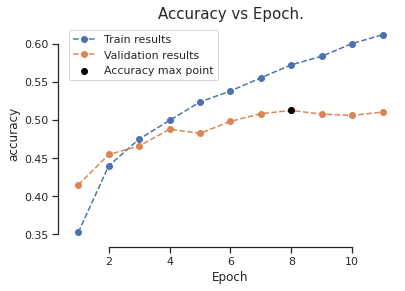

(8, 0.5127)

In [130]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=3, num_hidden_units=210, act_fn=torch.nn.SELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

Finished training after 223 seconds.


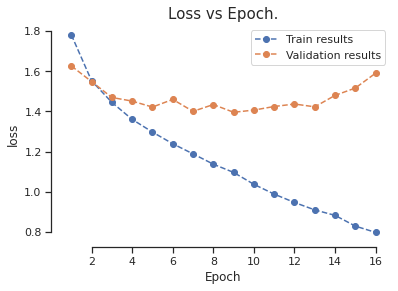

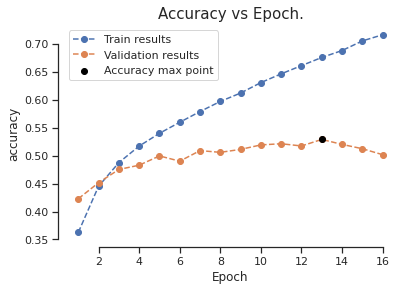

(13, 0.5289)

In [13]:
lr = 1e-3
# Model declaration
model = MLP(32, 3, 10, num_hidden_layers=3, num_hidden_units=210, act_fn=torch.nn.SELU())
model = model.to(device)

# Training
epochs = 100

early_stopper = EarlyStopper(patience=3)

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader, early_stopper)

plot("Loss vs Epoch.", "loss", train_losses, val_losses)
plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs, extra_pt=early_stopper.mtuple, extra_pt_label="Accuracy max point")
early_stopper.mtuple

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too! *(optional)*

In [36]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_pred = model(x.to(device))
            
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)
            
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] += 1
    
    return accuracy(epoch_correct, epoch_total), confusion_matrix

In [50]:
import pandas as pd
# The accuracy and confusion matrix
acc, confusion_matrix = test(testloader, model, device)

print("Accuracy:", acc)
print("Confussion matrix")
confusion_matrix

Accuracy: 0.5216
Confussion matrix


tensor([[603.,  32.,  42.,  19.,  42.,  26.,  20.,  53., 112.,  51.],
        [ 48., 584.,  20.,  15.,  18.,   9.,  16.,  34.,  79., 177.],
        [ 75.,  11., 380.,  80., 155.,  75.,  90.,  91.,  26.,  17.],
        [ 38.,  15.,  82., 315.,  69., 146., 144.,  90.,  37.,  64.],
        [ 44.,  10., 122.,  58., 472.,  37.,  94., 114.,  32.,  17.],
        [ 24.,  11.,  67., 204.,  79., 383.,  75.,  96.,  30.,  31.],
        [ 21.,  14.,  78.,  58.,  98.,  36., 601.,  40.,  15.,  39.],
        [ 24.,  12.,  39.,  61.,  80.,  62.,  31., 636.,  16.,  39.],
        [125.,  57.,  17.,  23.,  25.,  23.,   7.,  19., 654.,  50.],
        [ 61., 146.,  17.,  19.,  14.,  13.,   9.,  76.,  57., 588.]])

#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy? _Yes_
- If those values are different: How can you explain the difference? _It depends. More data, more correct answers, more accuracy_
- Why should you never use test set performance when trying out different hyper-parameters and architectures? _to avoid data leakage_